# Libraries

In [21]:
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os, sys, json

%matplotlib inline

In [22]:
DATA_DIR = os.path.join('..', 'input', 'shopee-product-matching')
RESULTS_DIR = os.path.join('..', 'working')
LOG_DIR = os.path.join('..', 'logs')
SUBMISSION_DIR = os.path.join('..', 'working')
MODEL_DIR = os.path.join('..', 'input', 'robertamodelobjects') # os.path.join('.') # 'roberta-base'

VERSION = '01'
MAX_SEQ_LEN = None
N_NEIGH = 50
POOLING_MODE = 'mean' # 'mean', 'sum'
BATCH_SIZE = 512

In [23]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Imports

In [28]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

if len(test_df) <= 3:
    df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
    TRAIN_FLAG = True
else:
    df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
    TRAIN_FLAG = False

In [29]:
VALID_SIZE = 0.2
VALID_ROWS = pd.Series(df['label_group'].unique()).sample(frac=VALID_SIZE, replace=False).values

train_df = df.loc[~df['label_group'].isin(VALID_ROWS)].copy().reset_index()
valid_df = df.loc[df['label_group'].isin(VALID_ROWS)].copy().reset_index()

print(df.shape, train_df.shape, valid_df.shape)
print(
    df.label_group.nunique(),
    train_df.label_group.nunique(),
    valid_df.label_group.nunique(),
    sum(
        pd.Series(train_df.label_group.unique()).isin(
            pd.Series(valid_df.label_group.unique())
        )
    )
)

(34250, 5) (27243, 6) (7007, 6)
11014 8811 2203 0


# EDA

In [30]:
train_df.columns, valid_df.columns, test_df.columns

(Index(['index', 'posting_id', 'image', 'image_phash', 'title', 'label_group'], dtype='object'),
 Index(['index', 'posting_id', 'image', 'image_phash', 'title', 'label_group'], dtype='object'),
 Index(['posting_id', 'image', 'image_phash', 'title'], dtype='object'))

In [31]:
pd.concat((train_df.isna().sum(), valid_df.isna().sum(), test_df.isna().sum()), axis=1)

,0,1,2
index,0,0,NaN
posting_id,0,0,0.0
image,0,0,0.0
image_phash,0,0,0.0
title,0,0,0.0
label_group,0,0,NaN


In [34]:
NUM_LABELS = train_df['label_group'].nunique()

label_counts = train_df.groupby('label_group')['posting_id'].count().sort_values(ascending=False)
MAX_GROUP_SIZE = label_counts.max()
MIN_GROUP_SIZE = label_counts.min()

print({
    'NUM_LABELS': NUM_LABELS,
    'MAX_GROUP_SIZE': MAX_GROUP_SIZE,
    'MIN_GROUP_SIZE': MIN_GROUP_SIZE,
})

{'NUM_LABELS': 8811, 'MAX_GROUP_SIZE': 51, 'MIN_GROUP_SIZE': 2}


In [35]:
label_counts.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    8811.000000
mean        3.091931
std         2.781068
min         2.000000
1%          2.000000
10%         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
90%         5.000000
99%        14.000000
max        51.000000
Name: posting_id, dtype: float64

(array([0.000e+00, 0.000e+00, 5.593e+03, 1.392e+03, 6.920e+02, 3.800e+02,
        2.350e+02, 1.320e+02, 9.200e+01, 7.300e+01, 3.900e+01, 3.200e+01,
        3.500e+01, 2.100e+01, 1.700e+01, 1.500e+01, 1.100e+01, 8.000e+00,
        3.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 <BarContainer object of 51 artists>)

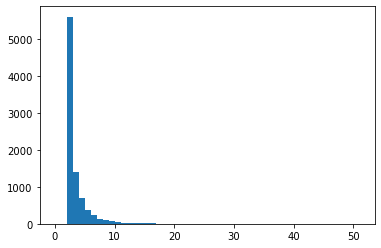

In [36]:
plt.hist(label_counts, bins=range(MAX_GROUP_SIZE + 1))

In [37]:
train_df.sample(5)

,index,posting_id,image,image_phash,title,label_group
15186,19179,train_1381716517,9095211bb81714a42075c97e5694c400.jpg,cbc785338495b5e4,Konicare minyak telon plus 30 ml,117207661
15908,20064,train_2981346764,96969d45fcaad4f11b9410d84750f242.jpg,b625723ed9d0c8cc,Rinso Molto Royal Gold Liquid 750 ml - Perlind...,1636098373
14391,18171,train_2766266426,88e2e251f80b7fadd96419b65631fcd0.jpg,beb4db929129c692,LEM T-7000 ZHANLIDA (50 ML),2095974075
23219,29217,train_3520906809,dafb0e0d7f9ef683aae3388979fd32cd.jpg,ba31c96526ce6d92,Bulan - Tere Liye,1632944269
5714,7187,train_2341594838,36614324fbcbc47773d753c5abcee1b1.jpg,f9b632d304f904f8,COD .Jilbab serut polos | serut polos | hijab ...,2047392365


### MAX Sequence Length

<AxesSubplot:>

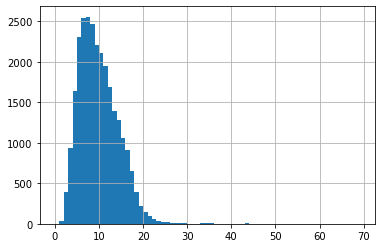

In [38]:
# train
train_df['num_words'] = train_df['title'].apply(lambda x: len(x.split(" ")))
train_df['num_words'].hist(bins=range(70))

<AxesSubplot:>

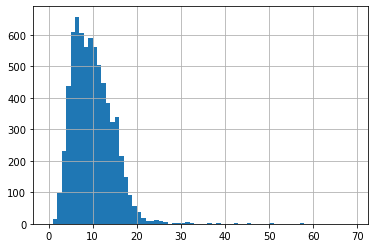

In [39]:
# valid
valid_df['num_words'] = valid_df['title'].apply(lambda x: len(x.split(" ")))
valid_df['num_words'].hist(bins=range(70))

<AxesSubplot:>

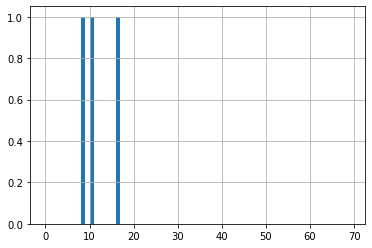

In [40]:
# test
test_df['num_words'] = test_df['title'].apply(lambda x: len(x.split(" ")))
test_df['num_words'].hist(bins=range(70))

# Model

In [41]:
with open(os.path.join(MODEL_DIR, "special_tokens_map.json")) as f:
    special_tokens = json.load(f)

roberta_tokenizer = RobertaTokenizer.from_pretrained(MODEL_DIR)
roberta_tokenizer.add_special_tokens(special_tokens)

roberta_config = RobertaConfig.from_pretrained(MODEL_DIR)
roberta_model = TFRobertaModel.from_pretrained(MODEL_DIR, config=roberta_config)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/robertamodelobjects.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [42]:
def create_text_features(titles, pooling_mode=POOLING_MODE, max_length=MAX_SEQ_LEN, verbose=False):
    tokenized_titles = roberta_tokenizer(titles, 
                                         return_tensors="tf", 
                                         padding=True, 
                                         truncation=True, 
                                         max_length=max_length)
    
    extracted_features = roberta_model(tokenized_titles, 
                                       return_dict=True)['last_hidden_state'] # (NUM_SAMPLES, SEQ_LEN, N_DIM)
    
    if verbose: print("Initial Shape: \t", extracted_features.shape)
    if pooling_mode == 'mean':
        extracted_features = extracted_features.numpy().mean(axis=1) # axis=1 represents the SEQ_LEN axis; over which we will aggregate
    else:
        extracted_features = extracted_features.numpy().sum(axis=1)
    
    if verbose: print("Final Shape: \t", extracted_features.shape)
    return extracted_features # (NUM_SAMPLES, N_DIM)

In [43]:
def batch_generator(arr, batch_size):
    for i in range(0, len(arr), batch_size):
        yield arr[i:i + batch_size]

In [51]:
@tf.function
def tf_cosine_similarity(u, v, N_NEIGH):
    u = tf.expand_dims(u, 1)
    n = tf.reduce_sum(u * v, axis=2)
    d = tf.linalg.norm(u, axis=2) * tf.linalg.norm(v, axis=1)
    distances = n / d
    indices = tf.math.top_k(tf.squeeze(distances), k=N_NEIGH).indices
    return indices

In [52]:
def find_matches(data, N_NEIGH=N_NEIGH):
    data = data.astype(np.float16)

    full_data = tf.cast(tf.multiply(data, 1), dtype=tf.float16)
    batch_data = tf.data.Dataset.from_tensor_slices(data).batch(32)

    results = []
    for x in batch_data:
        results.append(tf_cosine_similarity(x, full_data, N_NEIGH))

    results = tf.concat(results, axis=0)
    print(results.shape)

    results = results.numpy()
    
    return results

## Get Roberta Predictions

In [44]:
train_batches = batch_generator(train_df['title'].tolist(), BATCH_SIZE)
train_ext_features = [create_text_features(batch) for batch in train_batches]
train_ext_features = np.concatenate(train_ext_features, axis=0)

In [45]:
valid_batches = batch_generator(valid_df['title'].tolist(), BATCH_SIZE)
valid_ext_features = [create_text_features(batch) for batch in valid_batches]
valid_ext_features = np.concatenate(valid_ext_features, axis=0)

In [46]:
test_batches = batch_generator(test_df['title'].tolist(), BATCH_SIZE)
test_ext_features = [create_text_features(batch) for batch in test_batches]
test_ext_features = np.concatenate(test_ext_features, axis=0)

In [47]:
print(train_ext_features.shape, valid_ext_features.shape, test_ext_features.shape,)

(27243, 768) (7007, 768) (3, 768)


### Train data matches

In [48]:
train_indices = find_matches(data=train_ext_features)
train_df['matches'] = [" ".join([train_df['posting_id'][i] for i in row]) for row in train_indices]
train_df['matches'].head(10)

(27243, 50)


0    train_129225211 train_145656700 train_38059606...
1    train_3386243561 train_860027362 train_2112002...
2    train_2288590299 train_3803689425 train_943641...
3    train_1744956981 train_2406599165 train_352677...
4    train_3369186413 train_2095066661 train_110075...
5    train_1802986387 train_1827874369 train_670048...
6    train_86570404 train_2816190111 train_34394364...
7    train_841015183 train_1598329973 train_1384939...
8    train_2496690777 train_180115806 train_1031096...
9    train_2771755203 train_2496690777 train_215234...
Name: matches, dtype: object

### Valid data matches

In [49]:
valid_indices = find_matches(data=valid_ext_features)
valid_df['matches'] = [" ".join([valid_df['posting_id'][i] for i in row]) for row in valid_indices]
valid_df['matches'].head(10)

(7007, 50)


0    train_2464356923 train_1462484558 train_150123...
1    train_1806152124 train_3546299200 train_285008...
2    train_831680791 train_2163962683 train_6932343...
3    train_1872347548 train_4137127341 train_268438...
4    train_2905529497 train_3820243582 train_314033...
5    train_4193869534 train_1465987636 train_411925...
6    train_3497907844 train_2123729460 train_253177...
7    train_3921931335 train_3579417246 train_221757...
8    train_3241824372 train_4219739516 train_389052...
9    train_1612784649 train_92819142 train_17960643...
Name: matches, dtype: object

### Test data matches

In [54]:
try: 
    test_indices = find_matches(data=test_ext_features)
except ValueError as v:
    print("test-set only contains 3 samples hence setting n_neigh=2")
    test_indices = find_matches(data=test_ext_features, N_NEIGH=3)

test_df['matches'] = [" ".join([test_df['posting_id'][i] for i in row]) for row in test_indices]
test_df['matches'].head()

test-set only contains 3 samples hence setting n_neigh=2
(3, 3)


0    test_2255846744 test_4015706929 test_3588702337
1    test_3588702337 test_2255846744 test_4015706929
2    test_4015706929 test_2255846744 test_3588702337
Name: matches, dtype: object

## Creating outputs

In [55]:
train_df[['posting_id', 'matches']].to_csv(os.path.join(RESULTS_DIR, 'train_output.csv'), index=False)
test_df[['posting_id', 'matches']].to_csv(os.path.join(RESULTS_DIR, 'submission.csv'), index=False)